In [57]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.feature_extraction.dict_vectorizer import DictVectorizer

from sklearn.metrics.classification import classification_report, accuracy_score, confusion_matrix

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam, Adamax

N_FOLDS = 5
N_ITER = 50
SEED = 32

In [58]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def cat_vectorize(train_data, test_data, num_cols):
    # categorical attributes
    cat_train_data = train_data.drop(num_cols, axis=1)
    cat_test_data = test_data.drop(num_cols, axis=1)

    cat_train_data.fillna('NA', inplace=True)
    cat_test_data.fillna('NA', inplace=True)

    cat_train_data_values = cat_train_data.T.to_dict().values()
    cat_test_data_values = cat_test_data.T.to_dict().values()

    # vectorize (encode as one hot)
    vectorizer = DictVectorizer(sparse=False)
    vec_train_data = vectorizer.fit_transform(cat_train_data_values)
    vec_test_data = vectorizer.transform(cat_test_data_values)

    return vec_train_data, vec_test_data

In [59]:
# load dataframes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_full = [df_train, df_test]

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
for dataset in df_full:
    dataset['Last_Name'] = dataset['Name'].apply(lambda x: str.split(x, ",")[0])
    
    dataset['Name_length'] = dataset['Name'].apply(len)

    # Feature that tells whether a passenger had a cabin on the Titanic
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

    # Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    # Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    # Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

    # Remove all NULLS in the Fare column and create a new feature CategoricalFare
    dataset['Fare'] = dataset['Fare'].fillna(df_train['Fare'].median())

#     df_train['CategoricalFare'] = pd.qcut(df_train['Fare'], 4)

    # Create a New feature CategoricalAge
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

#     df_train['CategoricalAge'] = pd.cut(df_train['Age'], 5)

    # Create a new feature Title, containing the titles of passenger names
    dataset['Title'] = dataset['Name'].apply(get_title)

    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

    dataset = dataset.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp'], axis = 1)
    
df_train.head()

C:\Users\Ramvinojen\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1,1,0,A/5 21171,0,NaN,0,Braund,23,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,PC 17599,3,C85,1,Cumings,51,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1,0,0,STON/O2. 3101282,1,NaN,0,Heikkinen,22,0,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2,1,0,113803,3,C123,0,Futrelle,44,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2,0,0,373450,1,NaN,0,Allen,24,0,1,1,1


In [61]:
#SPLIT TRAIN AND VALIDATION SET
X_train, X_val, Y_train, Y_val = train_test_split(df_train.drop("Survived", axis=1), df_train["Survived"], test_size = 0.3)

In [79]:
X_test = df_test

X_trainVal = df_train[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Name_length","Has_Cabin","FamilySize","IsAlone","Title"]]
Y_trainVal = df_train["Survived"]
X_train = X_train[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Name_length","Has_Cabin","FamilySize","IsAlone","Title"]]
X_val = X_val[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Name_length","Has_Cabin","FamilySize","IsAlone","Title"]]
X_test = X_test[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Name_length","Has_Cabin","FamilySize","IsAlone","Title"]]

In [81]:
[X_trainVal.shape, Y_trainVal.shape, X_train.shape, Y_train.shape, X_val.shape, Y_val.shape]

[(891, 12), (891,), (623, 12), (623,), (268, 12), (268,)]

In [67]:
# Start neural network
model = Sequential()

model.add(Dense(50,input_dim=12))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dense(20))
#model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('selu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adamax(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train,Y_train, batch_size=100, epochs = 300, validation_data = (X_val,Y_val))

Train on 623 samples, validate on 268 samples
Epoch 1/300
623/623 [==============================] - 2s 3ms/step - loss: 1.0108 - acc: 0.4318 - val_loss: 0.8126 - val_acc: 0.3694
Epoch 2/300
623/623 [==============================] - 0s 42us/step - loss: 0.8964 - acc: 0.4398 - val_loss: 0.7485 - val_acc: 0.4179
Epoch 3/300
623/623 [==============================] - 0s 43us/step - loss: 0.8467 - acc: 0.4767 - val_loss: 0.7028 - val_acc: 0.5224
Epoch 4/300
623/623 [==============================] - 0s 52us/step - loss: 0.8150 - acc: 0.5040 - val_loss: 0.6643 - val_acc: 0.6045
Epoch 5/300
623/623 [==============================] - 0s 39us/step - loss: 0.7792 - acc: 0.5457 - val_loss: 0.6371 - val_acc: 0.7127
Epoch 6/300
623/623 [==============================] - 0s 44us/step - loss: 0.7190 - acc: 0.5602 - val_loss: 0.6186 - val_acc: 0.7201
Epoch 7/300
623/623 [==============================] - 0s 46us/step - loss: 0.6969 - acc: 0.6019 - val_loss: 0.6038 - val_acc: 0.7425
Epoch 8/300
623/6

623/623 [==============================] - 0s 42us/step - loss: 0.4744 - acc: 0.7737 - val_loss: 0.4359 - val_acc: 0.8097
Epoch 122/300
623/623 [==============================] - 0s 42us/step - loss: 0.4780 - acc: 0.7801 - val_loss: 0.4355 - val_acc: 0.8097
Epoch 123/300
623/623 [==============================] - 0s 36us/step - loss: 0.4939 - acc: 0.7737 - val_loss: 0.4350 - val_acc: 0.8060
Epoch 124/300
623/623 [==============================] - 0s 42us/step - loss: 0.4842 - acc: 0.7833 - val_loss: 0.4348 - val_acc: 0.8022
Epoch 125/300
623/623 [==============================] - 0s 48us/step - loss: 0.4730 - acc: 0.7929 - val_loss: 0.4342 - val_acc: 0.8022
Epoch 126/300
623/623 [==============================] - 0s 42us/step - loss: 0.4836 - acc: 0.7640 - val_loss: 0.4337 - val_acc: 0.8022
Epoch 127/300
623/623 [==============================] - 0s 41us/step - loss: 0.4970 - acc: 0.7833 - val_loss: 0.4335 - val_acc: 0.8022
Epoch 128/300
623/623 [==============================] - 0s 50

623/623 [==============================] - 0s 49us/step - loss: 0.4481 - acc: 0.8058 - val_loss: 0.4126 - val_acc: 0.8134
Epoch 242/300
623/623 [==============================] - 0s 37us/step - loss: 0.4450 - acc: 0.8074 - val_loss: 0.4130 - val_acc: 0.8172
Epoch 243/300
623/623 [==============================] - 0s 36us/step - loss: 0.4382 - acc: 0.8058 - val_loss: 0.4132 - val_acc: 0.8172
Epoch 244/300
623/623 [==============================] - 0s 41us/step - loss: 0.4587 - acc: 0.7961 - val_loss: 0.4129 - val_acc: 0.8172
Epoch 245/300
623/623 [==============================] - 0s 42us/step - loss: 0.4356 - acc: 0.8122 - val_loss: 0.4126 - val_acc: 0.8246
Epoch 246/300
623/623 [==============================] - 0s 44us/step - loss: 0.4347 - acc: 0.8026 - val_loss: 0.4125 - val_acc: 0.8246
Epoch 247/300
623/623 [==============================] - 0s 43us/step - loss: 0.4510 - acc: 0.7865 - val_loss: 0.4121 - val_acc: 0.8209
Epoch 248/300
623/623 [==============================] - 0s 46

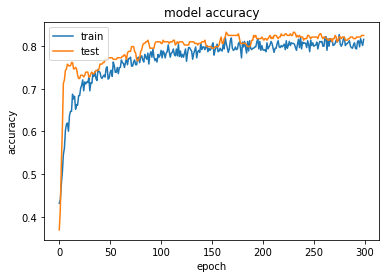

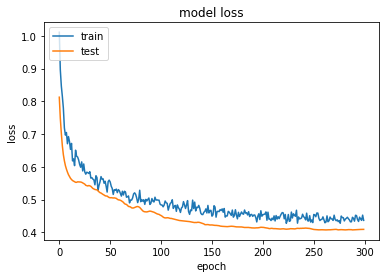

In [68]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
Y_pred = model.predict(X_test)

In [72]:
count = 0
for x in Y_pred:
    if x >= .5 :
        Y_pred[count] = 1
    else:
       Y_pred[count] = 0
    count = count + 1

In [76]:
df = pd.DataFrame({'PassengerId': df_test['PassengerId'],'Survived':Y_pred[:,0]})
df.to_csv("gender_submission.csv", sep=',')

In [82]:
from sklearn import svm

model_svm = svm.SVC(gamma='scale')
model_svm.fit(X_trainVal, Y_trainVal)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [83]:
Y_pred = model_svm.predict(X_test)

In [88]:
df = pd.DataFrame({'PassengerId': df_test['PassengerId'],'Survived':Y_pred})
df.to_csv("svm_gender_submission.csv", sep=',')